In [2]:
import numpy as np 
# import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [3]:
def concat_ones(data):
    
    size = len(data)
    new_data = np.concatenate((data, np.ones((size, 1))), axis=1)
    
    return new_data

def prepare_data():
    
    uv = concat_ones(np.load("9_uv.npy"))[:-3,:]
    xyz = concat_ones(np.load("9_xyz.npy"))[:-3,:]
    img = plt.imread("stereo2012a.jpg")
    origin_and_vanishing_pts = np.load("Vanishing XYZ.npy")

    return uv, xyz, img, origin_and_vanishing_pts

def projection_mse(actual, projected):    
    return np.mean((projected - actual)**2)

In [4]:
def get_camera_matrix_dlt(uv, xyz):
    
    # Initialise lists to store the equation and result matrix
    A = []
    b = []
    
    # Repeat for each real world point (xyz)
    for i, ele in enumerate(xyz):
        
        u = uv[i, 0]  # Store x-coordinate of pixel corresponding to the real world point (xyz)
        v = uv[i, 1]  # Store y-coordinate of pixel corresponding to the real world point (xyz)
        
        eq1 = np.concatenate((ele, [0,0,0,0], -ele*u))[:-1]  # Store the first equation  
        eq2 = np.concatenate(([0,0,0,0], ele, -ele*v))[:-1]  # Store the second equation
        
        # Add the equations to the equation matrix, A
        A.append(eq1)
        A.append(eq2)
        
        # Add pixel coordinates to the solution matrix, b
        b.append(u)
        b.append(v)

    A, b = np.array(A), np.array(b)
    
    # Solve the equations in 2N x 11 matrix, A using solutions from 2N matrix, by using least squares method
    # to approximately determine the Camera Calibration matrix, C (of length 11)
    C = np.linalg.lstsq(A, b, rcond=None)[0]
    
    # The last element of C is 1
    C = np.concatenate((C, [1]))
    
    # Reshape matrix C to dimensions 3 x 4
    C = C.reshape((3,4))
    
    return C

In [5]:
def xyz_to_uv(C, scaled_xyz):
    
    uv_preds = (C @ scaled_xyz[:,:,None]).reshape((-1,3))
    uv_preds = uv_preds[:,:2] / uv_preds[:,-1, None]
    
    return uv_preds

In [6]:
def visualise_results(img, uv, origin_and_vanishing_pts, uv_preds):

    # Show images
    fig, ax = plt.subplots(1, 2, figsize=(15,7))

    # Show selected points on input image
    ax[0].imshow(img)
    ax[0].scatter(uv[:,0], uv[:,1], s=5, marker = 'o', c='w')
    ax[0].set_title("Actual Selected points for Calibration")
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # Visualize lines from the origin to the vanishing points in the X, Y and Z direction
    color = 'red' # Line color
    ax[0].plot(origin_and_vanishing_pts[:2,0], origin_and_vanishing_pts[:2,1], c=color)
    ax[0].plot(origin_and_vanishing_pts[1:3,0], origin_and_vanishing_pts[1:3,1], c=color)
    ax[0].plot(origin_and_vanishing_pts[[1,3],0], origin_and_vanishing_pts[[1,3],1], c=color)

    # Show selected points on input image
    ax[1].imshow(img)
    ax[1].scatter(uv[:,0], uv[:,1], s=5, marker = 'o',c='w')
    ax[1].scatter(uv_preds[:,0], uv_preds[:,1], s=2, marker='x', c='b')
    ax[1].set_title("Projection Results (MSE = {})".format(projection_mse(uv[:,:2], uv_preds).round(4)))
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    # Visualize lines from the origin to the vanishing points in the X, Y and Z direction
    color = 'red' # Line color
    ax[1].plot(origin_and_vanishing_pts[:2,0], origin_and_vanishing_pts[:2,1], c=color)
    ax[1].plot(origin_and_vanishing_pts[1:3,0], origin_and_vanishing_pts[1:3,1], c=color)
    ax[1].plot(origin_and_vanishing_pts[[1,3],0], origin_and_vanishing_pts[[1,3],1], c=color)

    plt.show()

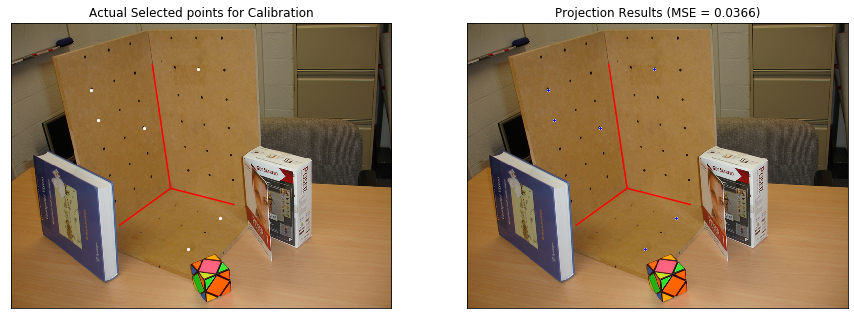

In [7]:
# Read image coordinates (u, v) and real world coordinates (x, y, z)
uv, xyz, img, origin_and_vanishing_pts = prepare_data()

# Calculate the Camera Matrix using Direct Linear Transformation (DLT)
C = get_camera_matrix_dlt(uv, xyz)

# Project x, y, z coordinates onto image plane 
uv_preds = xyz_to_uv(C, xyz)    

# Visualise actual u, v points and projections
visualise_results(img, uv, origin_and_vanishing_pts, uv_preds)

In [8]:
def vgg_rq(S):
    S = S.T
    [Q,U] = np.linalg.qr(S[::-1,::-1], mode='complete')

    Q = Q.T
    Q = Q[::-1, ::-1]
    U = U.T
    U = U[::-1, ::-1]
    if np.linalg.det(Q)<0:
        U[:,0] = -U[:,0]
        Q[0,:] = -Q[0,:]
    return U,Q


def vgg_KR_from_P(P, noscale = True):
    N = P.shape[0]
    H = P[:,0:N]
#     print(N,'|', H)
    [K,R] = vgg_rq(H)
    if noscale:
        K = K / K[N-1,N-1]
        if K[0,0] < 0:
            D = np.diag([-1, -1, np.ones([1,N-2])]);
            K = K @ D
            R = D @ R
        
            test = K*R; 
            assert (test/test[0,0] - H/H[0,0]).all() <= 1e-07
    
    t = np.linalg.inv(-P[:,0:N]) @ P[:,-1]
    return K, R, t

K, R, t = vgg_KR_from_P(C)

In [9]:
print("C = \n{}\n".format(C))
print("K = \n{}\n".format(K))
print("R = \n{}\n".format(R))
print("t = \n{}\n".format(t))

C = 
[[ 3.12730894e+01 -1.40240455e+01 -4.30879281e+01  3.23274638e+02]
 [ 1.38730589e+00 -5.20038773e+01  9.24338350e+00  3.34539259e+02]
 [-2.42420524e-02 -2.29675071e-02 -4.07428592e-02  1.00000000e+00]]

K = 
[[9.30703173e+02 5.86586264e-01 4.75466981e+02]
 [0.00000000e+00 9.62361485e+02 2.82565783e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

R = 
[[ 0.87283278 -0.06273827 -0.48396988]
 [ 0.16248051 -0.89776542  0.40941095]
 [-0.46017715 -0.43598297 -0.77340535]]

t = 
[11.2787209   9.00167195 12.75891537]



In [10]:
r31 = R[2,0]
r32 = R[2,1]
r33 = R[2,2]

tan_pitch_angle = -r31 / np.sqrt(r32**2 + r33**2)
pitch_angle = np.arctan(tan_pitch_angle)

print("Pitch Angle (in radians) = {}".format(pitch_angle))
print("Pitch Angle (in degrees) = {}".format(pitch_angle * 180 / np.pi))

Pitch Angle (in radians) = 0.4781947251163668
Pitch Angle (in degrees) = 27.398539534586362


In [11]:
# # Show images
# fig, ax = plt.subplots(1, 2, figsize=(15,7))

# # Show original stereo image
# ax[0].imshow(img)
# ax[0].set_title("Image (stereo2012a) for Camera Calibration")

# # Show selected points on input image
# ax[1].imshow(img)
# ax[1].scatter(uv[:,0], uv[:,1], s=2, c='w')
# ax[1].set_title("Selected points for Calibration")

# # Visualize lines from the origin to the vanishing points in the X, Y and Z direction
# color = 'red' # Line color
# ax[1].plot(origin_and_vanishing_pts[:2,0], origin_and_vanishing_pts[:2,1], c=color)
# ax[1].plot(origin_and_vanishing_pts[1:3,0], origin_and_vanishing_pts[1:3,1], c=color)
# ax[1].plot(origin_and_vanishing_pts[[1,3],0], origin_and_vanishing_pts[[1,3],1], c=color)

# plt.show()

In [12]:
def calibrate(im, XYZ, uv):
    
    # Concatenate 1 to every real world coordinate : [X Y Z] --> [X Y Z 1]
    XYZ = np.concatenate((XYZ, np.ones((len(XYZ), 1))), axis=1)
    
    # Initialise lists to store the equation and result matrix
    A = []
    b = []
    
    # Repeat for each real world point (XYZ)
    # where each element of XYZ is of the form [X Y Z 1]
    for i, ele in enumerate(XYZ):
        
        u = uv[i, 0]  # Store x-coordinate of pixel corresponding to the real world point (xyz)
        v = uv[i, 1]  # Store y-coordinate of pixel corresponding to the real world point (xyz)
        
        eq1 = np.concatenate((ele, [0,0,0,0], -ele*u))[:-1]  # Store the first equation  
        eq2 = np.concatenate(([0,0,0,0], ele, -ele*v))[:-1]  # Store the second equation
        
        # Add the equations to the equation matrix, A
        A.append(eq1)
        A.append(eq2)
        
        # Add pixel coordinates to the solution matrix, b
        b.append(u)
        b.append(v)

    A, b = np.array(A), np.array(b)
    
    # Solve the equations in 2N x 11 matrix, A using solutions from 2N matrix, by using least squares method
    # to approximately determine the Camera Calibration matrix, C (of length 11)
    C, residuals = np.linalg.lstsq(A, b, rcond=None)[:2]
    
    # Display the error in satisfying camera calibration matrix constraints
    print("Error in satisfying the camera calibration matrix constraints = {}".format(residuals[0]))
    
    # The last element of C is 1
    C = np.concatenate((C, [1]))
    
    # Reshape matrix C to dimensions 3 x 4
    C = C.reshape((3,4))
    
    # Project XYZ onto the 2D image plane
    uv_preds = (C @ XYZ[:,:,None]).reshape((-1,3))
    uv_preds = uv_preds[:,:2] / uv_preds[:,-1, None] # Normalise the coordinates using the last element (u = uw/w)
    
    # Compute projection error, mean squared error
    mse = np.mean((uv_preds - uv)**2)
    
    # Load Vanishing points
    origin_and_vanishing_pts = np.load("Vanishing XYZ.npy")
    
    # Plotting Code
    plt.imshow(im)
    plt.scatter(uv[:,0], uv[:,1], s=10, marker='o', c='w')
    plt.scatter(uv_preds[:,0], uv_preds[:,1], s=10, marker='x', c='b')
    plt.title("Projection Error (MSE) = %.5f"%mse)
    
    # Visualize lines from the origin to the vanishing points in the X, Y and Z direction
    color = 'red' # Line color
    plt.plot(origin_and_vanishing_pts[:2,0], origin_and_vanishing_pts[:2,1], c=color)
    plt.plot(origin_and_vanishing_pts[1:3,0], origin_and_vanishing_pts[1:3,1], c=color)
    plt.plot(origin_and_vanishing_pts[[1,3],0], origin_and_vanishing_pts[[1,3],1], c=color)
    
    plt.xticks([])
    plt.yticks([])
    plt.show()

    return C

Error in satisfying the camera calibration matrix constraints = 0.27954950188647415


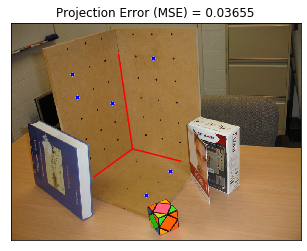

array([[ 3.12730894e+01, -1.40240455e+01, -4.30879281e+01,
         3.23274638e+02],
       [ 1.38730589e+00, -5.20038773e+01,  9.24338350e+00,
         3.34539259e+02],
       [-2.42420524e-02, -2.29675071e-02, -4.07428592e-02,
         1.00000000e+00]])

In [13]:
im = plt.imread("stereo2012a.jpg")
uv = np.load("9_uv.npy")[:-3]
XYZ = np.load("9_xyz.npy")[:-3]
calibrate(im=im, XYZ=XYZ, uv=uv)